In [42]:
import psycopg2
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [43]:
df = pd.read_csv('bank-full.csv', sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [44]:
#elimizde 17 sütun var. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [45]:
#veri setindeki sütun isimlerim ve yazım şeklini kontrol ediyoruz.
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [46]:
# "y"  hedef sütununun adını 'abone_durumu' olarak değişitirip en başa taşıyoruz 
df.rename(columns={'y': 'abone_durumu'}, inplace=True)
abone_durumu_column = df.pop('abone_durumu')  # "abone_durumu" sütununu çıkarır
df.insert(0, 'abone_durumu', abone_durumu_column)  # "abone_durumu" sütununu en başa ekler
df

,abone_durumu,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,no,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,no,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,no,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,no,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,no,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,yes,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,yes,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,yes,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,no,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


In [47]:
#default, housing ve abone_durumu sütunlarındaki yer alan yes ve no değerlerini 0 ve 1 yapıyoruz. 
df['default'] = df['default'].replace({'yes': 1, 'no': 0})
df['housing'] = df['housing'].replace({'yes': 1, 'no': 0})
df['loan'] = df['loan'].replace({'yes': 1, 'no': 0})
df['abone_durumu'] = df['abone_durumu'].replace({'yes': 1, 'no': 0})
df.head()

,abone_durumu,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown
1,0,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown
2,0,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown
3,0,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown
4,0,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown


In [48]:
# 'job' sütunundaki benzersiz değerleri alın
unique_job = df['job'].unique()
print("Unique job:", unique_job)

Unique job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


In [49]:
print(df['job'].value_counts())

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


In [50]:
#job sütununda bulunan mavi yakaya girebilecek meslekleri o kategoriye aldık.
df['job'] = df['job'].replace(['admin.', 'technician', 'services','housemaid'], 'blue-collar')
df.head()

,abone_durumu,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown
1,0,44,blue-collar,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown
2,0,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown
3,0,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown
4,0,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown


In [51]:
# 'management' değerlerini 'white-collar' olarak değiştirme
df['job'] = df['job'].replace('management', 'white-collar')

In [52]:
#job sütununda bulunan beyaz yakaya girebilecek meslekleri o kategoriye aldık.
df['job'] = df['job'].replace(['entrepreneur', 'self-employed',], 'white-collar')
df.head()

,abone_durumu,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,58,white-collar,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown
1,0,44,blue-collar,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown
2,0,33,white-collar,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown
3,0,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown
4,0,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown


In [53]:
#job sütununda yer alan 288 adet bilinmeyen değerleri sildik.
df = df[df['job'] != 'unknown']
df.head()

,abone_durumu,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,58,white-collar,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown
1,0,44,blue-collar,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown
2,0,33,white-collar,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown
3,0,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown
5,0,35,white-collar,married,tertiary,0,231,1,0,unknown,5,may,139,1,-1,0,unknown


In [54]:
# 'öğrenci' ve 'emekli' değerlerini 'other' olarak değiştirme
df['job'] = df['job'].replace(['student', 'retired'], 'other')

C:\Users\BETUL\AppData\Local\Temp\ipykernel_5084\2969398022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['job'] = df['job'].replace(['student', 'retired'], 'other')


In [55]:
#one-hot encoding uygulayacağız. Other sütunu emekli ve öğrencileri kapsıyor.
print(df['job'].value_counts())

job
blue-collar     27894
white-collar    12524
other            3202
unemployed       1303
Name: count, dtype: int64


In [56]:
#one-hot encoding uygulayacağız. 
print(df['marital'].value_counts())

marital
married     27011
single      12722
divorced     5190
Name: count, dtype: int64


In [57]:
#one-hot encoding uygulayacağız. 
print(df['education'].value_counts())

education
secondary    23131
tertiary     13262
primary       6800
unknown       1730
Name: count, dtype: int64


In [58]:
#one-hot encoding uygulayacağız. 
print(df['contact'].value_counts())

contact
cellular     29154
unknown      12909
telephone     2860
Name: count, dtype: int64


In [59]:
#one-hot encoding uygulayacağız. ???
print(df['poutcome'].value_counts())

poutcome
unknown    36704
failure     4881
other       1838
success     1500
Name: count, dtype: int64


In [60]:
df = pd.get_dummies(df, columns=['job','marital','education','contact','poutcome'], drop_first=True , dtype=int)
df

,abone_durumu,age,default,balance,housing,loan,day,month,duration,campaign,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,58,0,2143,1,0,5,may,261,1,...,1,0,0,1,0,0,1,0,0,1
1,0,44,0,29,1,0,5,may,151,1,...,0,1,1,0,0,0,1,0,0,1
2,0,33,0,2,1,1,5,may,76,1,...,1,0,1,0,0,0,1,0,0,1
3,0,47,0,1506,1,0,5,may,92,1,...,1,0,0,0,1,0,1,0,0,1
5,0,35,0,231,1,0,5,may,139,1,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,1,51,0,825,0,0,17,nov,977,3,...,1,0,0,1,0,0,0,0,0,1
45207,1,71,0,1729,0,0,17,nov,456,2,...,0,0,0,0,0,0,0,0,0,1
45208,1,72,0,5715,0,0,17,nov,1127,5,...,1,0,1,0,0,0,0,0,1,0
45209,0,57,0,668,0,0,17,nov,508,4,...,1,0,1,0,0,1,0,0,0,1


In [61]:
print(df['month'].value_counts())

month
may    13735
jul     6864
aug     6184
jun     5251
nov     3956
apr     2925
feb     2636
jan     1388
oct      727
sep      570
mar      474
dec      213
Name: count, dtype: int64


In [62]:
# Ay isimlerini sayısal değerlere dönüştürme
df['month'] = pd.to_datetime(df['month'], format='%b').dt.month

In [63]:
print(df['month'].value_counts())

month
5     13735
7      6864
8      6184
6      5251
11     3956
4      2925
2      2636
1      1388
10      727
9       570
3       474
12      213
Name: count, dtype: int64


In [64]:
df.head()

,abone_durumu,age,default,balance,housing,loan,day,month,duration,campaign,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,58,0,2143,1,0,5,5,261,1,...,1,0,0,1,0,0,1,0,0,1
1,0,44,0,29,1,0,5,5,151,1,...,0,1,1,0,0,0,1,0,0,1
2,0,33,0,2,1,1,5,5,76,1,...,1,0,1,0,0,0,1,0,0,1
3,0,47,0,1506,1,0,5,5,92,1,...,1,0,0,0,1,0,1,0,0,1
5,0,35,0,231,1,0,5,5,139,1,...,1,0,0,1,0,0,1,0,0,1


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44923 entries, 0 to 45210
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   abone_durumu         44923 non-null  int64
 1   age                  44923 non-null  int64
 2   default              44923 non-null  int64
 3   balance              44923 non-null  int64
 4   housing              44923 non-null  int64
 5   loan                 44923 non-null  int64
 6   day                  44923 non-null  int64
 7   month                44923 non-null  int32
 8   duration             44923 non-null  int64
 9   campaign             44923 non-null  int64
 10  pdays                44923 non-null  int64
 11  previous             44923 non-null  int64
 12  job_other            44923 non-null  int32
 13  job_unemployed       44923 non-null  int32
 14  job_white-collar     44923 non-null  int32
 15  marital_married      44923 non-null  int32
 16  marital_single       44923 

In [66]:
df.head()

,abone_durumu,age,default,balance,housing,loan,day,month,duration,campaign,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,58,0,2143,1,0,5,5,261,1,...,1,0,0,1,0,0,1,0,0,1
1,0,44,0,29,1,0,5,5,151,1,...,0,1,1,0,0,0,1,0,0,1
2,0,33,0,2,1,1,5,5,76,1,...,1,0,1,0,0,0,1,0,0,1
3,0,47,0,1506,1,0,5,5,92,1,...,1,0,0,0,1,0,1,0,0,1
5,0,35,0,231,1,0,5,5,139,1,...,1,0,0,1,0,0,1,0,0,1


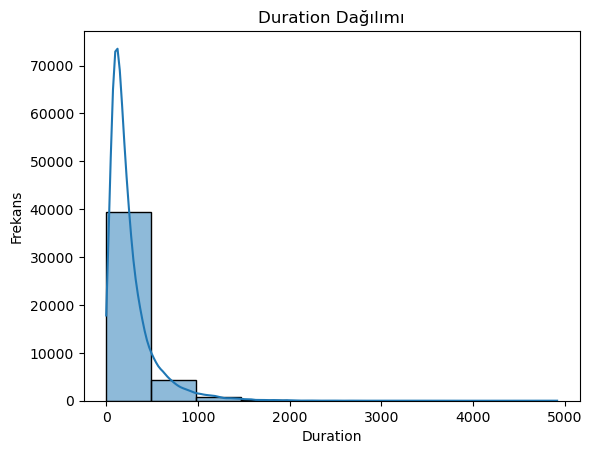

In [68]:
# Histogram ile aykırı değerleri göster
sns.histplot(df['duration'], bins=10, kde=True)
plt.title('Duration Dağılımı')
plt.xlabel('Duration')
plt.ylabel('Frekans')
plt.show()

In [75]:
# Duration sütununu belirli aralıklara bölelim
df['duration_aralik'] = pd.cut(df['duration'], bins=[0, 500, 1000, 1500, float('inf')], labels=['0-500', '501-1000', '1001-1500', '1500+'])

# Her bir aralıkta abone olma durumunu gözlemleyelim
grouped = df.groupby(['duration_aralik', 'abone_durumu']).size().unstack(fill_value=0)

print(grouped)

abone_durumu         0     1
duration_aralik             
0-500            36588  2990
501-1000          2652  1635
1001-1500          336   492
1500+               89   138


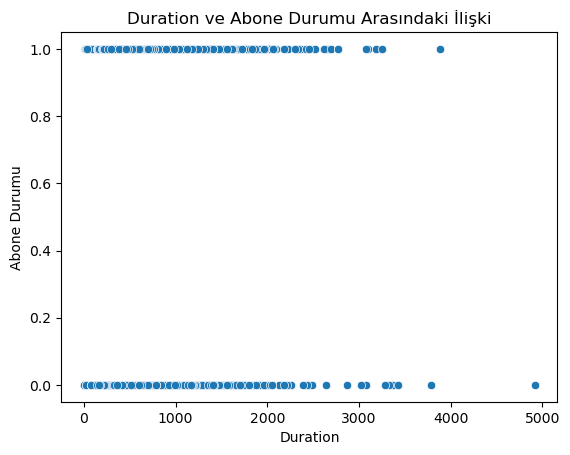

In [77]:
# Scatter plot
sns.scatterplot(x='duration', y='abone_durumu', data=df)
plt.title('Duration ve Abone Durumu Arasındaki İlişki')
plt.xlabel('Duration')
plt.ylabel('Abone Durumu')
plt.show()

In [81]:
# Duration sütununun yüzdelik dağılımını hesapla
duration_counts = df['duration'].value_counts(normalize=True) * 100

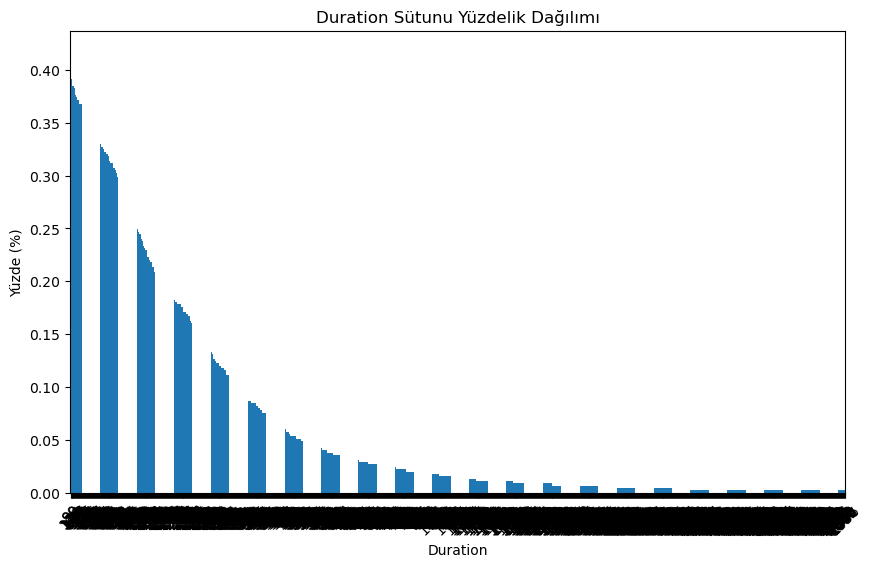

In [82]:
# Grafikte göster
plt.figure(figsize=(10, 6))
duration_counts.plot(kind='bar')
plt.title('Duration Sütunu Yüzdelik Dağılımı')
plt.xlabel('Duration')
plt.ylabel('Yüzde (%)')
plt.xticks(rotation=45)
plt.show()

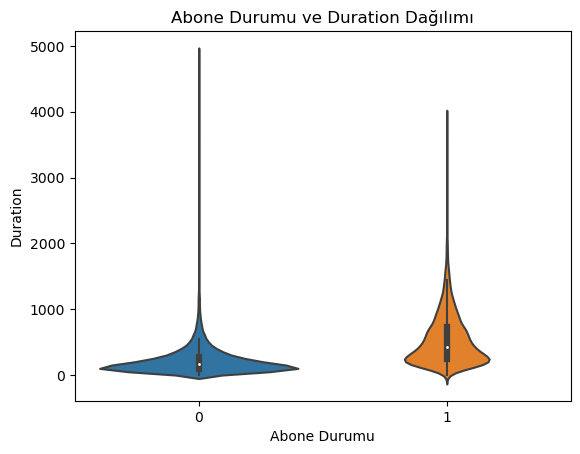

In [78]:
# Violin plot
sns.violinplot(x='abone_durumu', y='duration', data=df)
plt.title('Abone Durumu ve Duration Dağılımı')
plt.xlabel('Abone Durumu')
plt.ylabel('Duration')
plt.show()

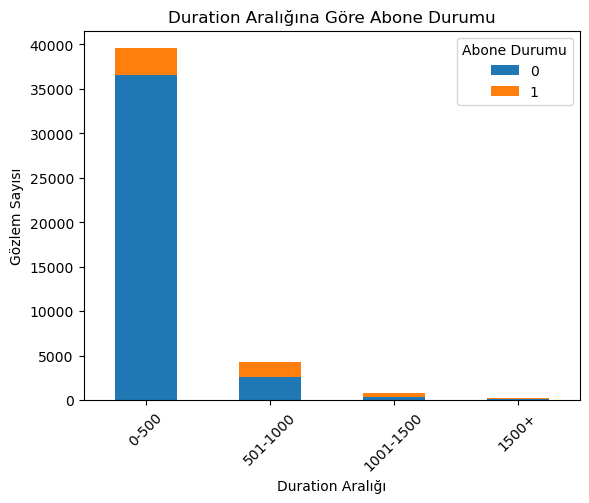

In [76]:
# Görselleştirme
grouped.plot(kind='bar', stacked=True)
plt.title('Duration Aralığına Göre Abone Durumu')
plt.xlabel('Duration Aralığı')
plt.ylabel('Gözlem Sayısı')
plt.xticks(rotation=45)
plt.legend(title='Abone Durumu')
plt.show()

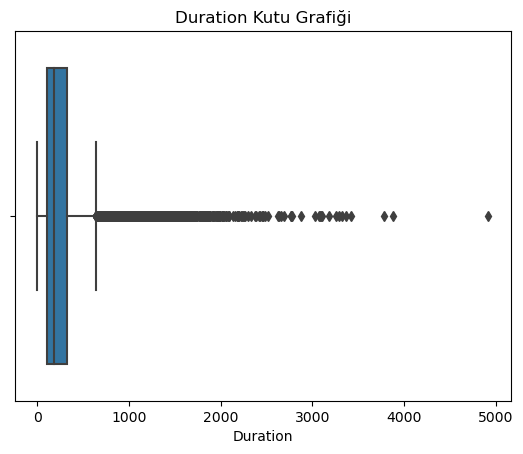

In [69]:
# Box plot ile aykırı değerleri göster
sns.boxplot(x=df['duration'])
plt.title('Duration Kutu Grafiği')
plt.xlabel('Duration')
plt.show()

In [70]:
# Standart sapma kullanarak aykırı değerleri tanımla ve say
mean = df['duration'].mean()
std_dev = df['duration'].std()
threshold = 2

outliers = df[(df['duration'] < mean - threshold * std_dev) | (df['duration'] > mean + threshold * std_dev)]
outlier_count = outliers.shape[0]

print("Standart Sapma Yöntemiyle Aykırı Değerler:")
print("Alt sınır:", mean - threshold * std_dev)
print("Üst sınır:", mean + threshold * std_dev)
print("Aykırı değerlerin sayısı:", outlier_count)

# Yüzdelikler kullanarak aykırı değerleri tanımla ve say
q_low = df['duration'].quantile(0.05)
q_hi  = df['duration'].quantile(0.95)

outliers_percentile = df[(df['duration'] < q_low) | (df['duration'] > q_hi)]
outliers_percentile_count = outliers_percentile.shape[0]

print("\nYüzdelik Yöntemiyle Aykırı Değerler:")
print("Alt sınır:", q_low)
print("Üst sınır:", q_hi)
print("Aykırı değerlerin sayısı:", outliers_percentile_count)

Standart Sapma Yöntemiyle Aykırı Değerler:
Alt sınır: -257.13270285183756
Üst sınır: 773.7223785190904
Aykırı değerlerin sayısı: 2087

Yüzdelik Yöntemiyle Aykırı Değerler:
Alt sınır: 35.0
Üst sınır: 751.0
Aykırı değerlerin sayısı: 4475


In [26]:
#veri setindeki sayısal değerleri inceliyoruz.
df.describe()

,abone_durumu,age,default,balance,housing,loan,day,month,duration,campaign,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
count,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,...,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000
mean,0.116978,40.893529,0.018098,1359.643011,0.558823,0.161165,15.813882,6.142844,258.294838,2.760345,...,0.601273,0.283196,0.514903,0.295216,0.038510,0.063664,0.287358,0.040914,0.033390,0.817042
std,0.321398,10.604399,0.133306,3045.091520,0.496533,0.367687,8.320040,2.408517,257.713770,3.092838,...,0.489642,0.450556,0.499783,0.456145,0.192427,0.244157,0.452535,0.198094,0.179656,0.386636
min,0.000000,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,5.000000,103.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,39.000000,0.000000,447.000000,1.000000,0.000000,16.000000,6.000000,180.000000,2.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,48.000000,0.000000,1421.000000,1.000000,0.000000,21.000000,8.000000,319.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,12.000000,4918.000000,63.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
#her sütunun yüzdelik dağılıma baktık
for column in df.columns:
    column_counts = df[column].value_counts(normalize=True) * 100
    print(f"--- {column} Sütunu Yüzdelik Dağılımı ---")
    print(column_counts)
    print()

--- abone_durumu Sütunu Yüzdelik Dağılımı ---
abone_durumu
0    88.302206
1    11.697794
Name: proportion, dtype: float64

--- age Sütunu Yüzdelik Dağılımı ---
age
32    4.639049
31    4.429802
33    4.371925
34    4.287336
35    4.200521
        ...   
93    0.004452
90    0.004452
95    0.004452
88    0.004452
94    0.002226
Name: proportion, Length: 77, dtype: float64

--- default Sütunu Yüzdelik Dağılımı ---
default
0    98.190237
1     1.809763
Name: proportion, dtype: float64

--- balance Sütunu Yüzdelik Dağılımı ---
balance
 0        7.759945
 1        0.431850
 2        0.345035
 4        0.309418
 3        0.291610
            ...   
-923      0.002226
-1445     0.002226
 10655    0.002226
 4153     0.002226
 16353    0.002226
Name: proportion, Length: 7142, dtype: float64

--- housing Sütunu Yüzdelik Dağılımı ---
housing
1    55.882287
0    44.117713
Name: proportion, dtype: float64

--- loan Sütunu Yüzdelik Dağılımı ---
loan
0    83.883534
1    16.116466
Name: proportion, dt

In [28]:
# Her sütunun yüzdelik dağılımını çubuk grafikle görselleştirme
#for column in df.columns:
   # column_counts = df[column].value_counts(normalize=True) * 100
   # plt.figure(figsize=(10, 6))
   # column_counts.plot(kind='bar')
   # plt.title(f"{column} Sütunu Yüzdelik Dağılımı")
   # plt.xlabel("Değerler")
   # plt.ylabel("Yüzde (%)")
   # plt.xticks(rotation=45)
   # plt.show()

In [29]:
#veri setinin yüzdelik dağılımını gözlemledik. Gözümüz aydın veri setimiz dengesiz.
df['abone_durumu'].value_counts(normalize=True)

abone_durumu
0    0.883022
1    0.116978
Name: proportion, dtype: float64

In [30]:
#train test ayrımı yaptık (%20-%80) dengesiz olduğu için stratify kullandık.
X_train, X_test, y_train, y_test = train_test_split(df.drop('abone_durumu', axis=1), df['abone_durumu'], 
                                                    test_size=0.2, random_state=42, stratify=df['abone_durumu'])

In [31]:
print(f'X_Train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_Train: (35938, 24), y_train: (35938,), X_test: (8985, 24), y_test: (8985,)


In [32]:
train_df = X_train.copy()
train_df['abone_durumu'] = y_train

In [33]:
#sns.pairplot(train_df, hue='abone_durumu');

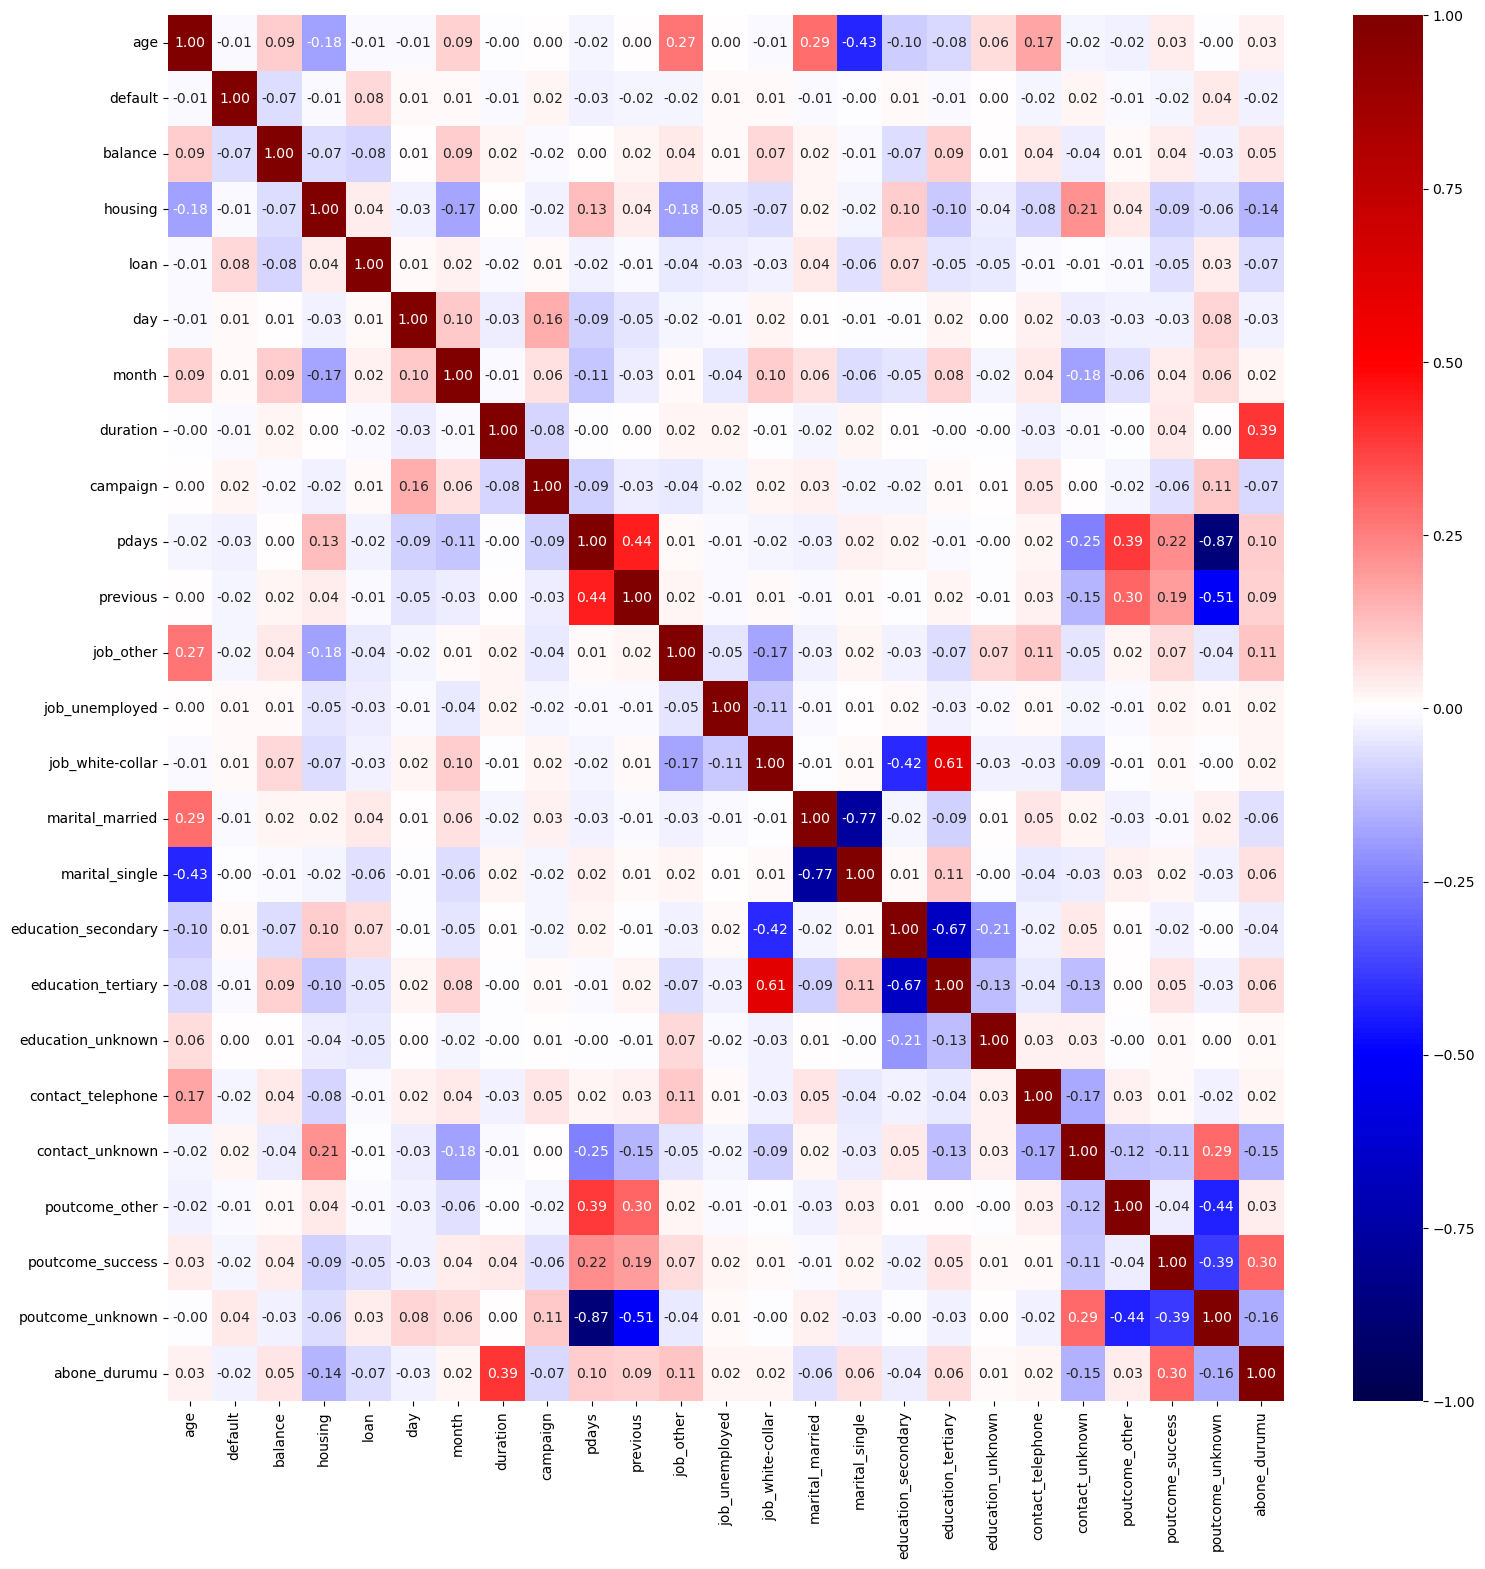

In [34]:
#previous ve pdays sütunları benzer davranışlar sergiliyor gibi belki multicolinarity! %44
#White-collar ve tertiary benzer davranışlar. %61
#poutcome_unknown ile pdays özellikler arası ilişki %-87 kaldırılabilir.!! (Ama 36.704 adet veri bulunduruyor)
#poutcome_unknown ile previous  özellikler arası ilişki %-51
#marital-single ile marital_married özellikler arası korelasyon değeri %77
plt.figure(figsize=[18,18])
sns.heatmap(train_df.corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

In [35]:
#poutcome_unknown ve marital_single sütunlarını veri setinden kaldırdık
df1 = df.drop(columns=['poutcome_unknown', 'marital_single'])

In [36]:
df1.head()

,abone_durumu,age,default,balance,housing,loan,day,month,duration,campaign,...,job_unemployed,job_white-collar,marital_married,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success
0,0,58,0,2143,1,0,5,5,261,1,...,0,1,1,0,1,0,0,1,0,0
1,0,44,0,29,1,0,5,5,151,1,...,0,0,0,1,0,0,0,1,0,0
2,0,33,0,2,1,1,5,5,76,1,...,0,1,1,1,0,0,0,1,0,0
3,0,47,0,1506,1,0,5,5,92,1,...,0,0,1,0,0,1,0,1,0,0
5,0,35,0,231,1,0,5,5,139,1,...,0,1,1,0,1,0,0,1,0,0


In [37]:
#train test ayrımı yaptık (%20-%80) dengesiz olduğu için stratify kullandık.
X_train, X_test, y_train, y_test = train_test_split(df1.drop('abone_durumu', axis=1), df1['abone_durumu'], 
                                                    test_size=0.2, random_state=42, stratify=df1['abone_durumu'])

In [38]:
train_df1 = X_train.copy()
train_df1['abone_durumu'] = y_train

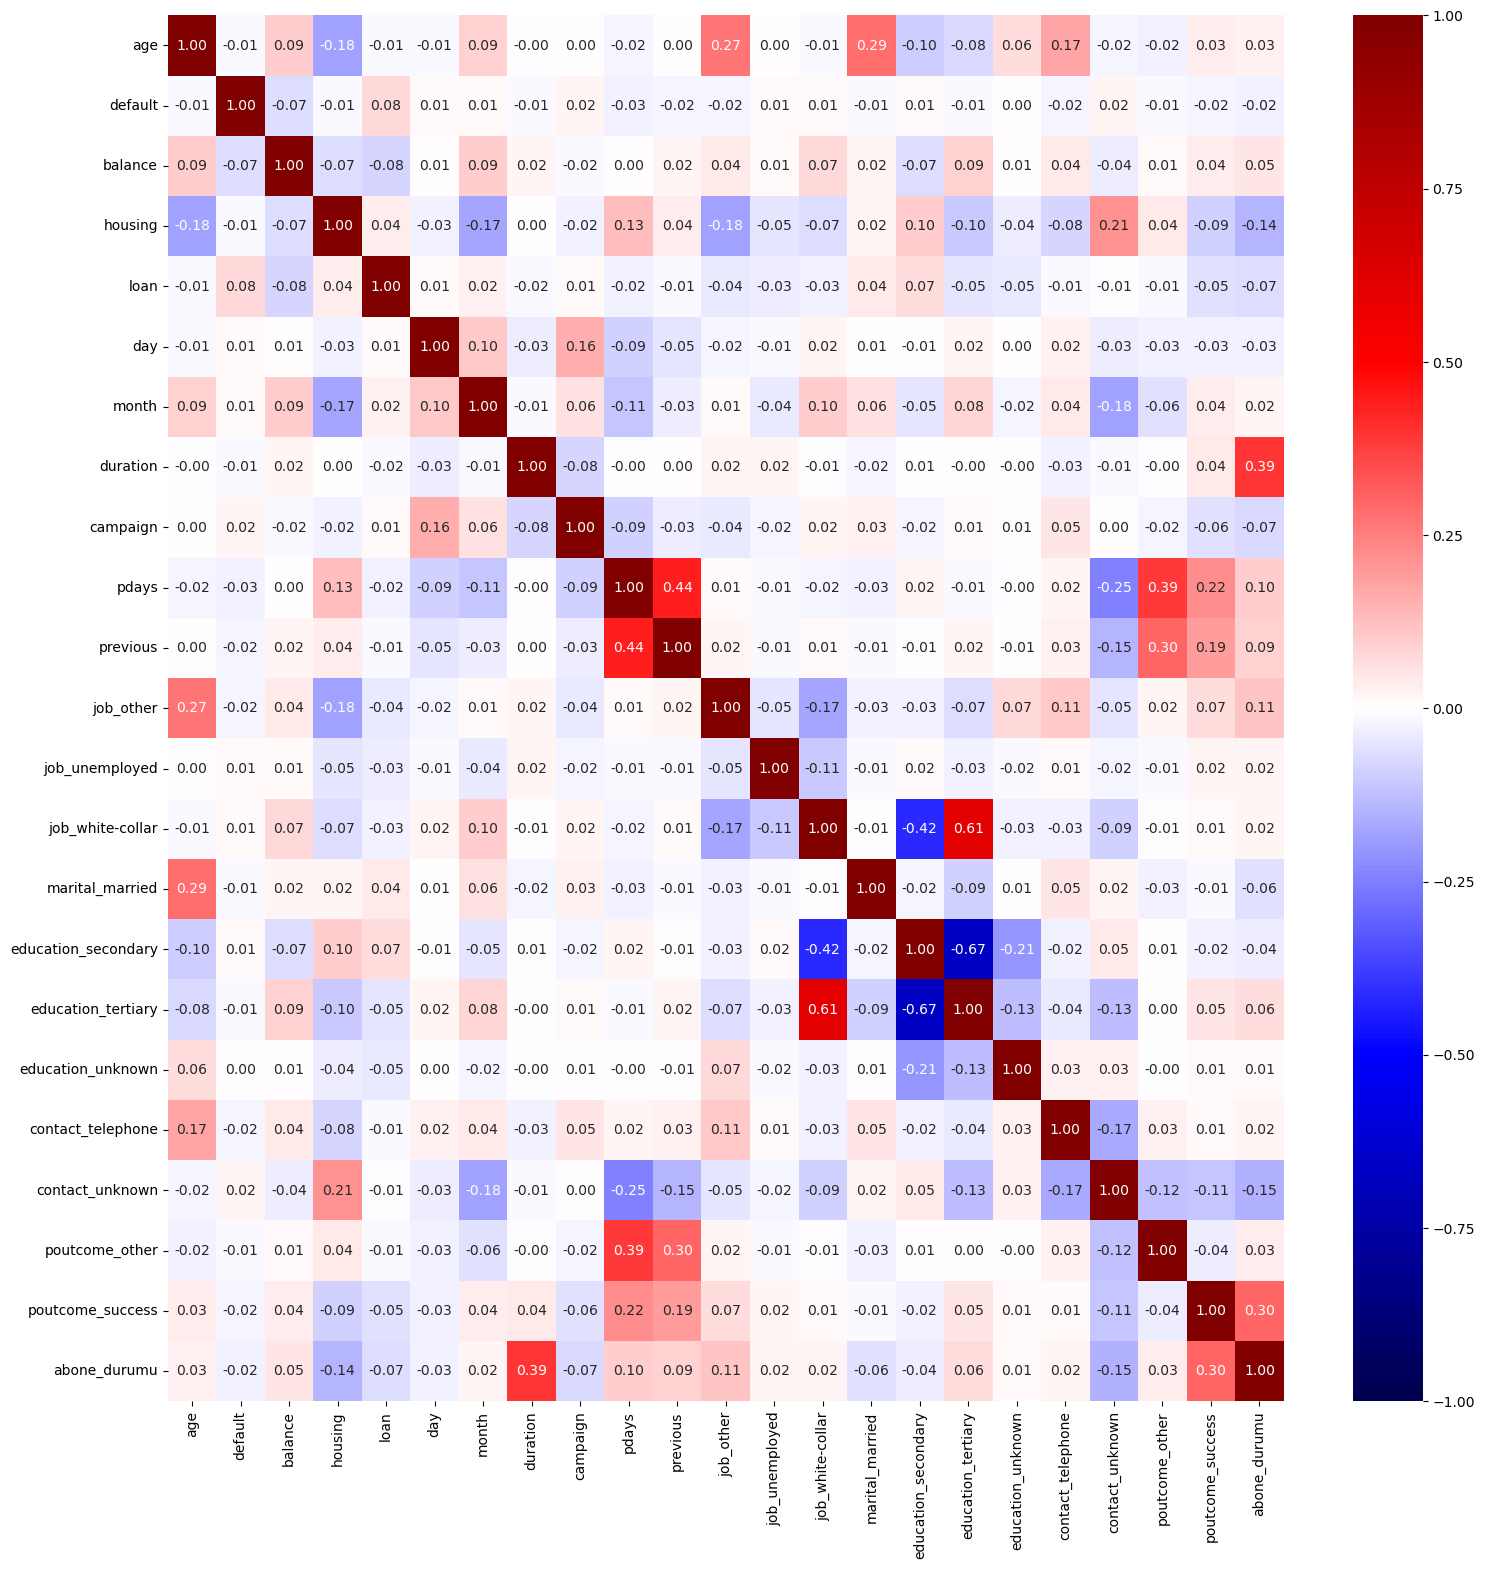

In [39]:
plt.figure(figsize=[18,18])
sns.heatmap(train_df1.corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

In [40]:
# DataFrame'i CSV dosyasına kaydetme
df1.to_csv('df1.csv', index=False)

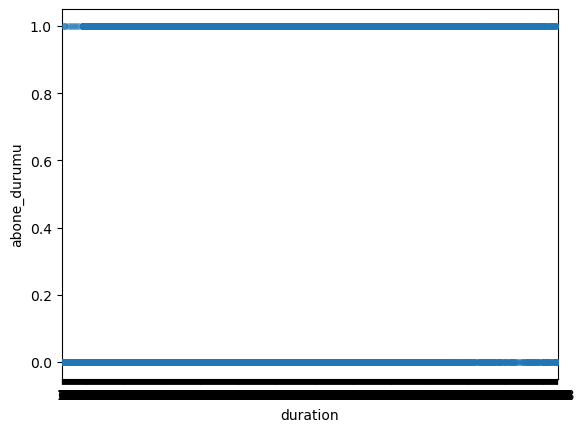

In [41]:
sns.stripplot(x='duration', y='abone_durumu', data=train_df1, alpha=0.6);